# MFIN7034 Problem Set 1 – Factor Model
In this problem set, you will run regressions to understand how factor models work in (cross-sectional and time-series) asset return analysis.

Data sources:
1. https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research
2. https://global-q.org/factors.html
3. https://finance.wharton.upenn.edu/~stambaug/

To match the datasets for stock returns, use monthly versions with time range from 2000-01 to 2022-12 for all factor datasets. \
Submission: Proper visualization and clear interpretations & discussions, such as explaining why the coefficient of a factor change over time, will also be graded.

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [32]:
return_df = pd.read_csv('data/monthly_stock_returns.csv')
return_df['Month'] = pd.to_datetime(return_df['YYYYMM'], format='%Y%m')
return_df.drop(columns=['YYYYMM'], inplace=True)
return_df.apply(pd.to_numeric, errors='coerce').astype(float)
return_df.head()

,PERMNO,MthPrc,MthRet,Month
0,10324,52.0000,0.155556,2000-01-01
1,10324,57.4375,0.104567,2000-02-01
2,10324,50.1250,-0.127312,2000-03-01
3,10324,48.8125,-0.026185,2000-04-01
4,10324,56.8125,0.163892,2000-05-01


In [33]:
ff5_df = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, header=0, skip_blank_lines=False)
empty_row_index = np.where(ff5_df.iloc[:, 0].isnull())[0][0]
ff5_df = ff5_df.iloc[:empty_row_index] 
ff5_df['Month'] = pd.to_datetime(ff5_df.iloc[:, 0], format='%Y%m')
ff5_df.drop(ff5_df.columns[0], axis=1, inplace=True)
ff5_df.loc[:, ff5_df.columns != 'Month'] = ff5_df.loc[:, ff5_df.columns != 'Month'].apply(pd.to_numeric, errors='coerce').astype(float)
ff5_df.loc[:, ff5_df.columns != 'Month'] = ff5_df.loc[:, ff5_df.columns != 'Month'] / 100
ff5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,Month
0,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,1963-07-01
1,0.0507,-0.008,0.018,0.0036,-0.0035,0.0025,1963-08-01
2,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,1963-09-01
3,0.0253,-0.0139,-0.001,0.028,-0.0201,0.0029,1963-10-01
4,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,1963-11-01


In [34]:
q5_df = pd.read_csv('data/q5_factors_monthly_2023.csv')
q5_df['Month'] = pd.to_datetime(
    q5_df['year'].astype(str) + '-' + q5_df['month'].astype(str).str.zfill(2), # zfill(2): '1' -> '01', padding
    format="%Y-%m"
)
q5_df.drop(columns=['year', 'month'], inplace=True)
q5_df.loc[:, ff5_df.columns != 'Month'] = q5_df.loc[:, ff5_df.columns != 'Month'].apply(pd.to_numeric, errors='coerce').astype(float)
q5_df.loc[:, ff5_df.columns != 'Month'] = q5_df.loc[:, ff5_df.columns != 'Month'] / 100
q5_df.head()

,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,Month
0,0.003927,0.081852,0.068122,-0.029263,0.018813,-0.025511,1967-01-01
1,0.003743,0.007557,0.016235,-0.002915,0.035399,0.021792,1967-02-01
2,0.003693,0.040169,0.019836,-0.016772,0.018417,-0.011192,1967-03-01
3,0.003344,0.038786,-0.006700,-0.028972,0.010253,-0.016371,1967-04-01
4,0.003126,-0.042807,0.027366,0.021864,0.006038,0.001191,1967-05-01


In [35]:
liq_df = pd.read_csv('data/liq_data_1962_2023.txt', sep=r'\t', skiprows=10, engine='python')
liq_df['Month'] = pd.to_datetime(liq_df['% Month'], format='%Y%m')
liq_df.drop(columns=['% Month'], inplace=True)
liq_df.loc[:, liq_df.columns != 'Month'] = liq_df.loc[:, liq_df.columns != 'Month'].apply(pd.to_numeric, errors='coerce').astype(float)
liq_df.head()

,Agg Liq.,Innov Liq (eq8),Traded Liq (LIQ_V),Month
0,-0.017537,0.004260,-99.0,1962-08-01
1,-0.004075,0.011757,-99.0,1962-09-01
2,-0.104212,-0.074128,-99.0,1962-10-01
3,-0.019742,0.028572,-99.0,1962-11-01
4,-0.005089,0.013037,-99.0,1962-12-01


## Task 1: Factor Regression (Naive)
For each stock, each month, use the data from 60 months ago (including the current month) to the previous month (it is okay if the sample has less than 60 months as long as it can be estimated in OLS), and run regression (“rolling-window regression”). Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF".

In [36]:
# merging data
factor_reg_df = pd.merge(return_df, ff5_df, how='inner', on='Month')
factor_reg_df = pd.merge(factor_reg_df, q5_df, how='inner', on='Month')
factor_reg_df = pd.merge(factor_reg_df, liq_df, how='inner', on='Month')

# construct excess return
factor_reg_df['MthRet-RF'] = factor_reg_df['MthRet'] - factor_reg_df['RF']

# Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF"
factor_reg_df.drop(columns=['R_MKT', 'R_F', 'RF'], inplace=True)

In [37]:
def run_rolling_window_regression(
    factor_reg_df: pd.DataFrame,
    stock_ids: np.ndarray,
    factor_names: list,
    window_size = 60,
    min_window_size = 40
) -> pd.DataFrame:
    """
    Runs rolling window regression for stock returns analysis.
    
    Args:
        factor_reg_df: DataFrame containing factor regression data
        stock_ids: All stock ids
        factor_names: List of factor names to include in the model
        
    Returns:
        DataFrame with regression results for each stock and month
    """
    
    # Initialize result DataFrame
    result = []
    skip_ids = []
    col_names = [n + '_beta' for n in factor_names]

    # Run regression for all stocks
    for stock in tqdm(stock_ids):
        curr_df = factor_reg_df[factor_reg_df['PERMNO'] == stock].reset_index()
        
        # Skip stocks with insufficient data
        if len(curr_df) < min_window_size:
            skip_ids.append(stock)
            continue
            
        for i in range(min_window_size, len(curr_df)):
            # Select appropriate window size
            if i < window_size:
                window_df = curr_df.iloc[i-min_window_size: i]
            else:
                window_df = curr_df.iloc[i-window_size: i]
                
            time_stamp = curr_df['Month'][i]
            
            # Run regression
            X = sm.add_constant(window_df[factor_names])
            y = window_df['MthRet-RF']
            model = sm.OLS(y.astype(float), X.astype(float)).fit()
            
            # Create result row
            res_row = {
                'PERMNO': stock,
                'Month': time_stamp,
                **dict(zip(['alpha'] + col_names, model.params))
            }
            
            result.append(res_row)
    
    return pd.DataFrame(result)

factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'Agg Liq.', 'Innov Liq (eq8)', 'Traded Liq (LIQ_V)']
result_df = run_rolling_window_regression(factor_reg_df, np.array([10324]), factor_names)

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


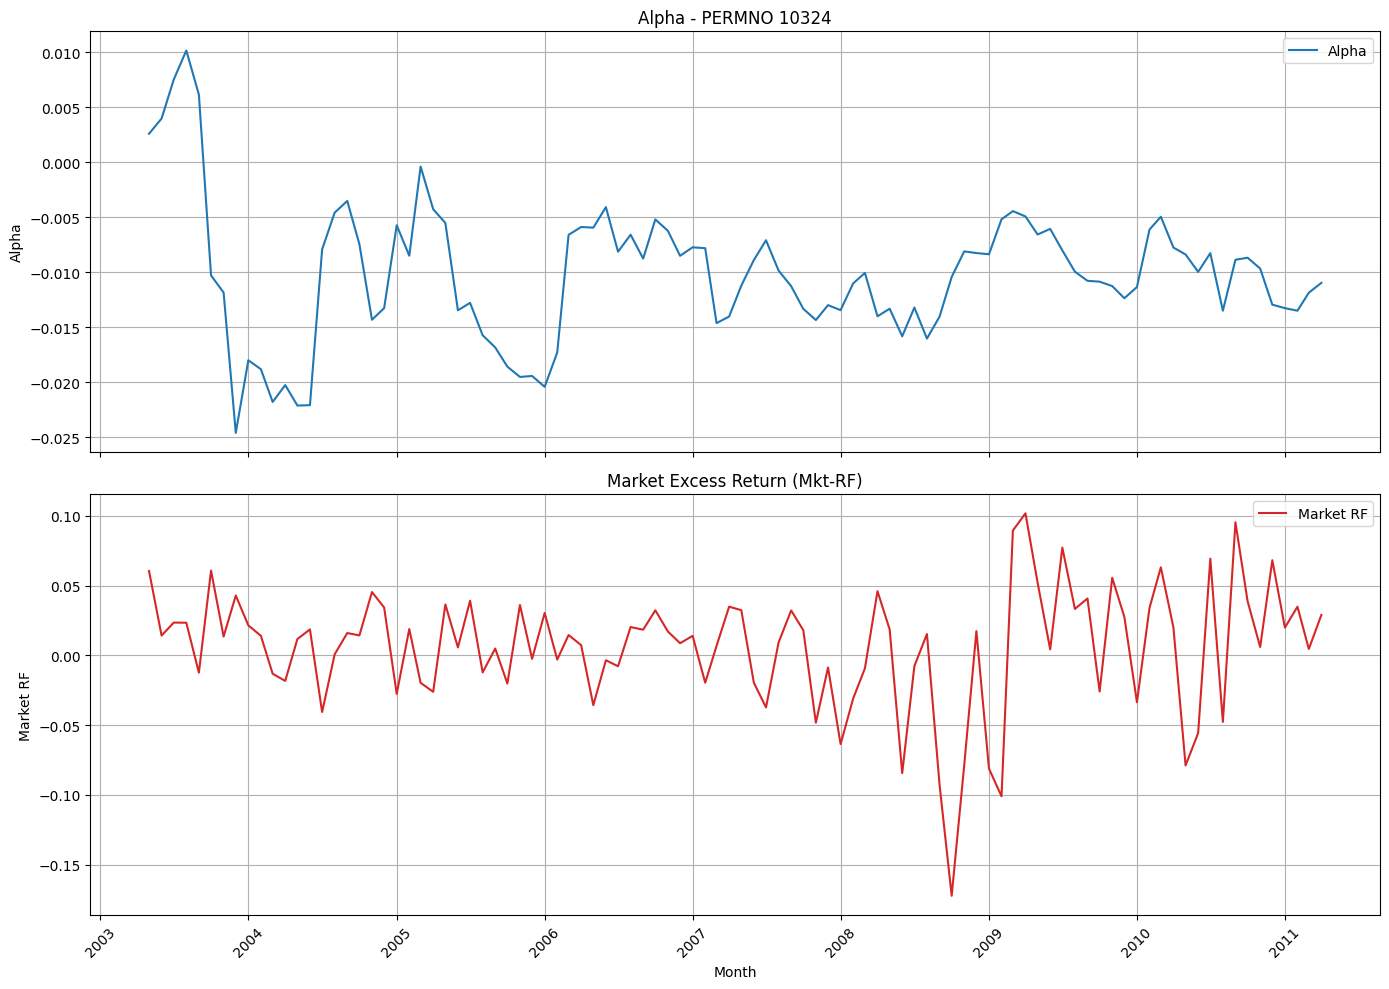

In [38]:
# Prepare data
alpha_df = result_df[result_df['PERMNO'] == 10324][['Month', 'alpha']]

# Merge with Market RF data
plot_df = pd.merge(
    alpha_df,
    ff5_df[['Month', 'Mkt-RF']],
    on='Month',
    how='inner'
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Alpha
ax1.plot(plot_df['Month'], plot_df['alpha'], color='tab:blue', label='Alpha')
ax1.set_title('Alpha - PERMNO 10324', fontsize=12)
ax1.set_ylabel('Alpha')
ax1.legend()
ax1.grid(True)

# Plot Market RF
ax2.plot(plot_df['Month'], plot_df['Mkt-RF'], color='tab:red', label='Market RF')
ax2.set_title('Market Excess Return (Mkt-RF)', fontsize=12)
ax2.set_ylabel('Market RF')
ax2.legend()
ax2.grid(True)

# Formatting
plt.xticks(rotation=45)
plt.xlabel('Month')
fig.tight_layout()
plt.show()

## Task 2: Fama-MacBeth Regression

In [39]:
# merging data
factor_reg_df = pd.merge(return_df, ff5_df, how='inner', on='Month')
factor_reg_df = pd.merge(factor_reg_df, q5_df, how='inner', on='Month')
factor_reg_df = pd.merge(factor_reg_df, liq_df, how='inner', on='Month')

# construct excess return
factor_reg_df['MthRet-RF'] = factor_reg_df['MthRet'] - factor_reg_df['RF']

# Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF"
factor_reg_df.drop(columns=['R_MKT', 'R_F', 'RF'], inplace=True)

In [40]:
stock_ids = return_df['PERMNO'].unique()
factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'Agg Liq.', 'Innov Liq (eq8)', 'Traded Liq (LIQ_V)']

In [41]:
# ===== Stage 1 =====: for each asset, estimate betas (factor loadings) with a time-series regression
# apply rolling window
beta_df = run_rolling_window_regression(factor_reg_df, stock_ids, factor_names, window_size=60, min_window_size=60)

100%|██████████| 573/573 [03:05<00:00,  3.10it/s]


In [44]:
# ===== Stage 2 =====: run the cross-sectional regression with a constant
# For each time period, run a cross-sectional regressions of returns on the same collection of betas, for each asset
col_names = [n + '_lambda' for n in factor_names]
beta_names = [n + '_beta' for n in factor_names]
result = []

# process data for regression, use betas as independent variables
cross_section_reg_df = pd.merge(factor_reg_df[['Month', 'PERMNO', 'MthRet-RF']], beta_df, how='inner', on=['PERMNO', 'Month'])

# loop over each time period
for t, group_df in tqdm(cross_section_reg_df.groupby(cross_section_reg_df['Month'])):

  # run cross-sectional regression
  X = sm.add_constant(group_df[beta_names]).astype(float)
  y = group_df['MthRet-RF'].astype(float)
  model = sm.OLS(y, X).fit()

  # create result row
  col_names = [n + '_lambda' for n in factor_names]
  row = {
    'PERMNO': id,
    'Month': t,
    **dict(zip(['const'] + col_names, model.params))
  }
  
  result.append(row)

result_df = pd.DataFrame(result)

  0%|          | 0/216 [00:00<?, ?it/s]

100%|██████████| 216/216 [00:00<00:00, 256.21it/s]


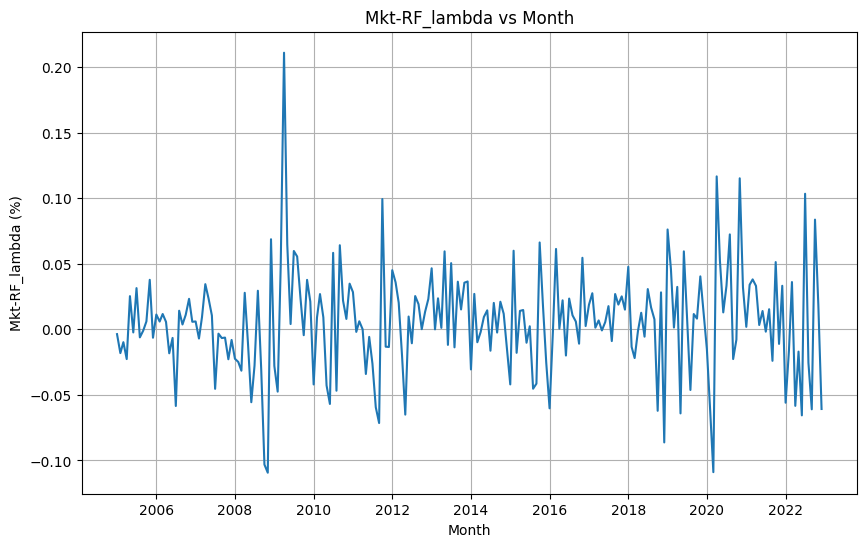

In [45]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result_df['Month'], result_df['Mkt-RF_lambda'], linestyle='-')
plt.title('Mkt-RF_lambda vs Month')
plt.xlabel('Month')
plt.ylabel('Mkt-RF_lambda (%)')
plt.grid(True)
plt.show()

## Task 3: LASSO Regression

In [46]:
# merging data
factor_reg_df = pd.merge(return_df, ff5_df, how='inner', on='Month')
factor_reg_df = pd.merge(factor_reg_df, q5_df, how='inner', on='Month')
factor_reg_df = pd.merge(factor_reg_df, liq_df, how='inner', on='Month')

# construct excess return
factor_reg_df['MthRet-RF'] = factor_reg_df['MthRet'] - factor_reg_df['RF']

# Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF"
factor_reg_df.drop(columns=['R_MKT', 'R_F', 'RF'], inplace=True)

stock_ids = return_df['PERMNO'].unique()
factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'Agg Liq.', 'Innov Liq (eq8)', 'Traded Liq (LIQ_V)']

# Create lagged factors
lagged_factor_names = []

# Generate lagged factor versions (0-6 months)
for factor in factor_names:
    for lag in range(0, 7):
        factor_reg_df[f'{factor}_l{lag}'] = factor_reg_df[factor].shift(lag)
        lagged_factor_names.append(f'{factor}_l{lag}')
    factor_reg_df.drop(factor, axis=1, inplace=True)

# Filter data to requested time period
factor_reg_df = factor_reg_df[
    (factor_reg_df['Month'] >= '2005-01-01') &
    (factor_reg_df['Month'] <= '2022-12-31')
]

factor_reg_df.head()

,PERMNO,MthPrc,MthRet,Month,MthRet-RF,Mkt-RF_l0,Mkt-RF_l1,Mkt-RF_l2,Mkt-RF_l3,Mkt-RF_l4,...,Innov Liq (eq8)_l4,Innov Liq (eq8)_l5,Innov Liq (eq8)_l6,Traded Liq (LIQ_V)_l0,Traded Liq (LIQ_V)_l1,Traded Liq (LIQ_V)_l2,Traded Liq (LIQ_V)_l3,Traded Liq (LIQ_V)_l4,Traded Liq (LIQ_V)_l5,Traded Liq (LIQ_V)_l6
60,10324,58.21,0.002411,2005-01-01,0.000811,-0.0276,0.0343,0.0454,0.0143,0.016,...,0.001032,0.048512,-0.013100,0.042384,-0.034320,0.013829,-0.015765,-0.001458,0.065207,0.071817
61,10324,56.09,-0.036420,2005-02-01,-0.03802,0.0189,-0.0276,0.0343,0.0454,0.0143,...,0.018567,0.001032,0.048512,0.055837,0.042384,-0.034320,0.013829,-0.015765,-0.001458,0.065207
62,10324,57.24,0.020503,2005-03-01,0.018403,-0.0197,0.0189,-0.0276,0.0343,0.0454,...,0.032061,0.018567,0.001032,-0.003001,0.055837,0.042384,-0.034320,0.013829,-0.015765,-0.001458
63,10324,58.52,0.022362,2005-04-01,0.020262,-0.0261,-0.0197,0.0189,-0.0276,0.0343,...,-0.020172,0.032061,0.018567,-0.052957,-0.003001,0.055837,0.042384,-0.034320,0.013829,-0.015765
64,10324,62.39,0.066131,2005-05-01,0.063731,0.0365,-0.0261,-0.0197,0.0189,-0.0276,...,0.011714,-0.020172,0.032061,0.000146,-0.052957,-0.003001,0.055837,0.042384,-0.034320,0.013829


In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from tqdm import tqdm

def run_rolling_window_lasso(
    factor_reg_df: pd.DataFrame,
    stock_ids: np.ndarray,
    factor_names: list,
    window_size: int,
    min_window_size: int,
    alpha: float = 0.001
) -> pd.DataFrame:
    """
    Runs rolling window LASSO regression for stock returns analysis with lagged factors.
    
    Args:
        factor_reg_df: DataFrame containing factor regression data
        stock_ids: All stock ids
        factor_names: List of factor names to include in the model
        window_size: Number of months in the rolling window
        min_window_size: Minimum number of months required for regression
        alpha: Penalty term for LASSO regression
        
    Returns:
        DataFrame with regression results and factor prevalence for each month
    """

    result = []

    # Run regression for all stocks
    for stock in tqdm(stock_ids):
        curr_df = factor_reg_df[factor_reg_df['PERMNO'] == stock].reset_index()
        
        # Skip stocks with insufficient data
        if len(curr_df) < min_window_size:
            continue
            
        for i in range(min_window_size, len(curr_df)):
            # Select appropriate window size
            if i < window_size:
                window_df = curr_df.iloc[i-min_window_size: i]
            else:
                window_df = curr_df.iloc[i-window_size: i]
                
            time_stamp = curr_df['Month'][i]
            
            # Prepare lagged features
            X = window_df[factor_names]
            y = window_df['MthRet-RF']

            # Run LASSO regression
            model = Lasso(alpha=alpha)
            model.fit(X, y)
            
            # Create result row
            res_row = {
                'PERMNO': stock,
                'Month': time_stamp,
                'alpha': model.intercept_,
                **dict(zip(factor_names, model.coef_))
            }
            result.append(res_row)
            
    return pd.DataFrame(result)

In [48]:
result_df_lasso = run_rolling_window_lasso(factor_reg_df, stock_ids, lagged_factor_names, window_size=60, min_window_size=60)

100%|██████████| 573/573 [02:06<00:00,  4.53it/s]


In [50]:
result_df_lasso.head()

,PERMNO,Month,alpha,Mkt-RF_l0,Mkt-RF_l1,Mkt-RF_l2,Mkt-RF_l3,Mkt-RF_l4,Mkt-RF_l5,Mkt-RF_l6,...,Innov Liq (eq8)_l4,Innov Liq (eq8)_l5,Innov Liq (eq8)_l6,Traded Liq (LIQ_V)_l0,Traded Liq (LIQ_V)_l1,Traded Liq (LIQ_V)_l2,Traded Liq (LIQ_V)_l3,Traded Liq (LIQ_V)_l4,Traded Liq (LIQ_V)_l5,Traded Liq (LIQ_V)_l6
0,10324,2010-01-01,-0.001967,0.0,0.0,0.0,-0.0,0.0,0.000000,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
1,10324,2010-02-01,0.001147,0.0,0.0,0.0,-0.0,0.0,0.000000,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2,10324,2010-03-01,0.003081,0.0,0.0,0.0,-0.0,0.0,0.000000,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
3,10324,2010-04-01,0.000709,0.0,0.0,0.0,-0.0,0.0,0.017602,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
4,10324,2010-05-01,0.000941,0.0,0.0,0.0,-0.0,0.0,0.012853,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0


In [92]:
result_prevalence = []
# Calculate the prevalence of each factor for each month
for month, month_df in tqdm(result_df_lasso.groupby('Month')):
    # calculating the prevalence, the ratio of number of stocks explained by this factor
    prevalence_i = (month_df[lagged_factor_names].abs() > 1e-6).sum() / len(month_df)
    prevalence_i['Month'] = month
    result_prevalence.append(prevalence_i)

result_prevalence_df = pd.DataFrame(result_prevalence)
result_prevalence_df.head()

100%|██████████| 156/156 [00:00<00:00, 639.19it/s]


,Mkt-RF_l0,Mkt-RF_l1,Mkt-RF_l2,Mkt-RF_l3,Mkt-RF_l4,Mkt-RF_l5,Mkt-RF_l6,SMB_l0,SMB_l1,SMB_l2,...,Innov Liq (eq8)_l5,Innov Liq (eq8)_l6,Traded Liq (LIQ_V)_l0,Traded Liq (LIQ_V)_l1,Traded Liq (LIQ_V)_l2,Traded Liq (LIQ_V)_l3,Traded Liq (LIQ_V)_l4,Traded Liq (LIQ_V)_l5,Traded Liq (LIQ_V)_l6,Month
0,0.884956,0.035398,0.022124,0.026549,0.084071,0.013274,0.030973,0.004425,0.0,0.0,...,0.101770,0.097345,0.132743,0.013274,0.039823,0.057522,0.035398,0.057522,0.022124,2010-01-01
1,0.884956,0.035398,0.022124,0.026549,0.079646,0.013274,0.026549,0.004425,0.0,0.0,...,0.101770,0.092920,0.123894,0.017699,0.039823,0.048673,0.030973,0.053097,0.013274,2010-02-01
2,0.888889,0.035556,0.022222,0.026667,0.075556,0.013333,0.026667,0.004444,0.0,0.0,...,0.111111,0.097778,0.124444,0.013333,0.035556,0.044444,0.026667,0.057778,0.022222,2010-03-01
3,0.901786,0.040179,0.017857,0.013393,0.071429,0.017857,0.040179,0.004464,0.0,0.0,...,0.116071,0.089286,0.125000,0.022321,0.026786,0.044643,0.026786,0.053571,0.026786,2010-04-01
4,0.893333,0.035556,0.017778,0.013333,0.075556,0.026667,0.035556,0.004444,0.0,0.0,...,0.111111,0.084444,0.120000,0.022222,0.031111,0.040000,0.026667,0.053333,0.035556,2010-05-01


In [93]:
# Ensure 'Month' is the index (if not already)
result_prevalence_df.set_index('Month', inplace=True)

# Function to get the top 5 factors for each month
def get_top_5_factors(row):
    return row.sort_values(ascending=False).head(5).index.tolist()

# Apply the function to each row (month) and create a new DataFrame
top_5_factors_df = result_prevalence_df.apply(get_top_5_factors, axis=1, result_type='expand')

# Rename columns for clarity
top_5_factors_df.columns = ['Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5']

# Display the result
top_5_factors_df.head()

,Top_1,Top_2,Top_3,Top_4,Top_5
Month,,,,,
2010-01-01,Mkt-RF_l0,Agg Liq._l0,Traded Liq (LIQ_V)_l0,Agg Liq._l4,Innov Liq (eq8)_l1
2010-02-01,Mkt-RF_l0,Agg Liq._l0,Innov Liq (eq8)_l1,Traded Liq (LIQ_V)_l0,Agg Liq._l1
2010-03-01,Mkt-RF_l0,Agg Liq._l0,Innov Liq (eq8)_l1,Traded Liq (LIQ_V)_l0,Innov Liq (eq8)_l0
2010-04-01,Mkt-RF_l0,Agg Liq._l0,Innov Liq (eq8)_l1,Traded Liq (LIQ_V)_l0,Innov Liq (eq8)_l5
2010-05-01,Mkt-RF_l0,Agg Liq._l0,Innov Liq (eq8)_l1,Traded Liq (LIQ_V)_l0,Innov Liq (eq8)_l5
